# Proyecto de Pruebas A/B: Evaluación del Sistema de Recomendaciones


## **Descripción General**

Este proyecto evalúa los resultados de una prueba A/B realizada por una tienda en línea internacional. La prueba busca determinar si un sistema mejorado de recomendaciones incrementa la conversión de los usuarios en tres etapas clave del embudo:

1. **Vistas de la página del producto (product_page).**
2. **Agregar productos al carrito (product_cart).**
3. **Compras (purchase).**

### **Especificaciones Técnicas**
- **Nombre de la prueba:** recommender_system_test
- **Grupos:** 
  - A: Control
  - B: Nuevo sistema de recomendaciones
- **Período de prueba:** 
  - **Inicio:** 2020-12-07
  - **Fin de inscripción de nuevos usuarios:** 2020-12-21
  - **Finalización:** 2021-01-01
- **Audiencia:** 15% de los nuevos usuarios de la región UE
- **Objetivo:** Incrementar al menos un 10% la conversión en cada etapa del embudo.
- **Número esperado de participantes:** 6,000

### **Estructura de Datos**
Los datos disponibles se dividen en cuatro archivos:
1. **Eventos de marketing:** Información de campañas publicitarias.
2. **Usuarios nuevos:** Detalles de los usuarios que se registraron durante la prueba.
3. **Eventos de usuarios:** Actividades registradas de los usuarios nuevos.
4. **Participantes de la prueba:** Asignación de usuarios a grupos A/B.


## **Carga y Preprocesamiento de Datos**

### Pasos:
1. Cargar los datasets.
2. Convertir tipos de datos si es necesario.
3. Verificar valores nulos o duplicados y tratarlos.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
marketing_events = pd.read_csv('/datasets/ab_project_marketing_events_us.csv')
new_users = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv')
events = pd.read_csv('/datasets/final_ab_events_upd_us.csv')
participants = pd.read_csv('/datasets/final_ab_participants_upd_us.csv')


In [3]:
print("Marketing Events:")
print(marketing_events.head(), '\n')
print("New Users:")
print(new_users.head(), '\n')
print("Events:")
print(events.head(), '\n')
print("Participants:")
print(participants.head())

Marketing Events:
                           name                   regions    start_dt  \
0      Christmas&New Year Promo             EU, N.America  2020-12-25   
1  St. Valentine's Day Giveaway  EU, CIS, APAC, N.America  2020-02-14   
2        St. Patric's Day Promo             EU, N.America  2020-03-17   
3                  Easter Promo  EU, CIS, APAC, N.America  2020-04-12   
4             4th of July Promo                 N.America  2020-07-04   

    finish_dt  
0  2021-01-03  
1  2020-02-16  
2  2020-03-19  
3  2020-04-19  
4  2020-07-11   

New Users:
            user_id  first_date     region   device
0  D72A72121175D8BE  2020-12-07         EU       PC
1  F1C668619DFE6E65  2020-12-07  N.America  Android
2  2E1BF1D4C37EA01F  2020-12-07         EU       PC
3  50734A22C0C63768  2020-12-07         EU   iPhone
4  E1BDDCE0DAFA2679  2020-12-07  N.America   iPhone 

Events:
            user_id             event_dt event_name  details
0  E1BDDCE0DAFA2679  2020-12-07 20:22:03   purchase

## Comentarios sobre la Carga y Preprocesamiento de Datos

- **Eventos de Marketing:** Los eventos están bien definidos con nombres, regiones y fechas de inicio y finalización. Es importante asegurarse de que las fechas y regiones sean consistentes para el análisis posterior.
- **Nuevos Usuarios:** La tabla de nuevos usuarios incluye identificadores, fechas de primer uso, regiones y dispositivos. Es crucial verificar si hay usuarios duplicados y asegurar que las fechas estén en el formato adecuado.
- **Eventos de Usuarios:** Los eventos de usuarios están correctamente registrados con información relevante como el identificador del usuario, fecha del evento, tipo de evento y detalles del evento. Se debe validar que no haya registros erróneos o duplicados, y que los eventos sean coherentes con el propósito del análisis.
- **Participantes en la Prueba A/B:** La tabla de participantes muestra correctamente la asignación de grupos (A/B) para el sistema de recomendaciones. Es necesario verificar que los grupos estén distribuidos equitativamente y que los usuarios estén correctamente asignados a cada grupo.



## **Análisis Exploratorio de Datos (EDA)**

### Objetivos:
1. Analizar la conversión en cada etapa del embudo.
2. Evaluar la distribución de eventos por usuario y por día.
3. Detectar posibles anomalías en los datos antes de iniciar la prueba A/B.


In [4]:
embudo_etapas = ['product_page', 'product_cart', 'purchase']
conversion_por_evento = events[events['event_name'].isin(embudo_etapas)].groupby('event_name')['user_id'].nunique()

In [5]:
total_usuarios = participants['user_id'].nunique()
conversion_tasa = (conversion_por_evento / total_usuarios) * 100
print("Conversión por evento (en porcentaje):")
print(conversion_tasa)

Conversión por evento (en porcentaje):
event_name
product_cart    141.399032
product_page    285.445080
purchase        143.481449
Name: user_id, dtype: float64


In [6]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

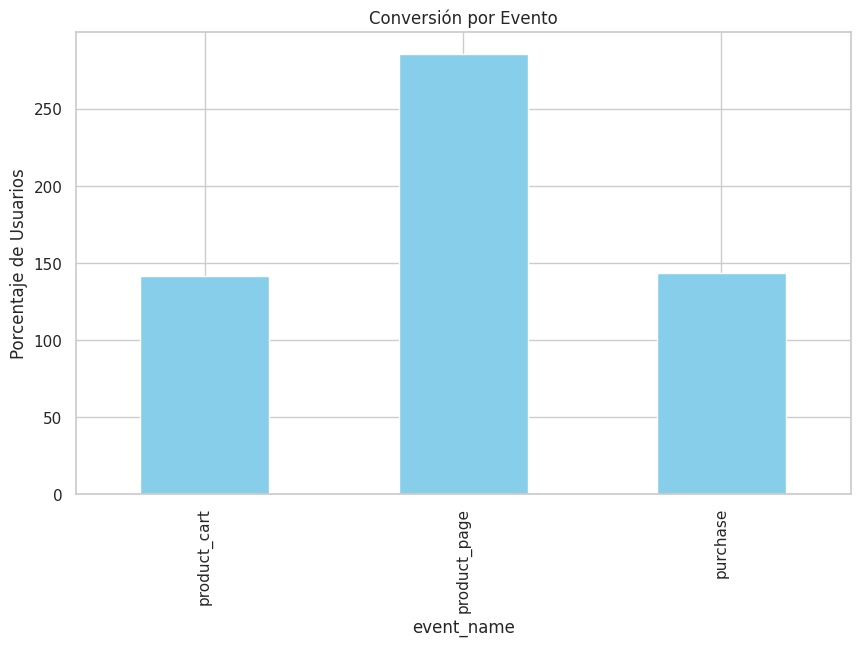

In [7]:
conversion_tasa.plot(kind='bar', color='skyblue', title='Conversión por Evento')
plt.ylabel('Porcentaje de Usuarios')
plt.show()

In [8]:
usuarios_grupo_duplicados = participants.groupby('user_id')['group'].nunique()
print("Usuarios en ambos grupos:", usuarios_grupo_duplicados[usuarios_grupo_duplicados > 1].count())

Usuarios en ambos grupos: 441


## **Evaluación de Resultados de la Prueba A/B**

### Pasos:
1. Verificar si las conversiones cumplen con el objetivo del 10%.
2. Aplicar pruebas estadísticas (prueba z para proporciones).
3. Evaluar si las diferencias son estadísticamente significativas.


In [9]:
events_converted = pd.merge(events, participants[['user_id', 'group']], on='user_id', how='left')

events_filtrados = events_converted[events_converted['event_name'].isin(embudo_etapas)]

conversion_por_evento_grupo = events_filtrados.groupby(['group', 'event_name'])['user_id'].nunique().unstack(fill_value=0)

total_usuarios_grupo = participants.groupby('group')['user_id'].nunique()

conversion_tasa_grupo = (conversion_por_evento_grupo / total_usuarios_grupo.values.reshape(-1, 1)) * 100

print("Conversión por evento y grupo:")
print(conversion_por_evento_grupo)

Conversión por evento y grupo:
event_name  product_cart  product_page  purchase
group                                           
A                   2483          5208      2682
B                   2037          3986      2008


In [10]:
print("Tasa de conversión por evento y grupo (en porcentaje):")
print(conversion_tasa_grupo)




Tasa de conversión por evento y grupo (en porcentaje):
event_name  product_cart  product_page   purchase
group                                            
A              31.534163     66.141732  34.061468
B              32.828364     64.238517  32.360999


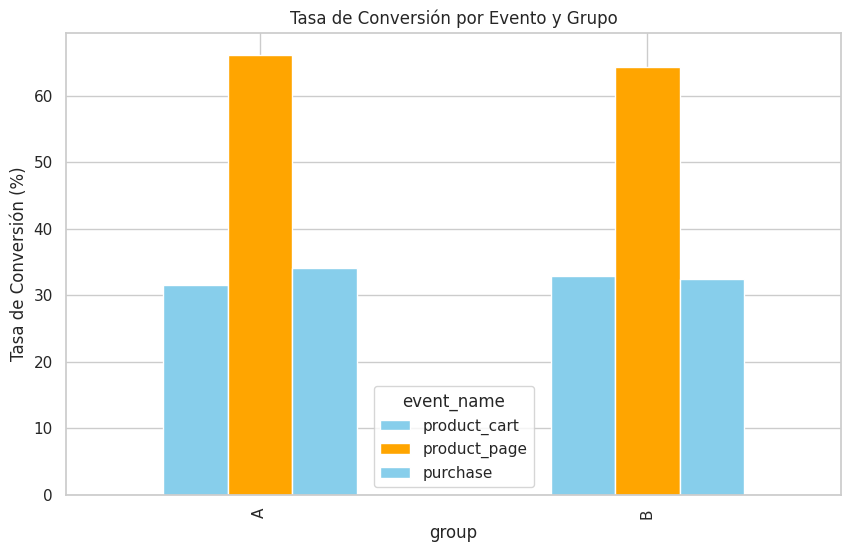

In [11]:
# Visualización de la tasa de conversión
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
conversion_tasa_grupo.plot(kind='bar', color=['skyblue', 'orange'], title='Tasa de Conversión por Evento y Grupo')
plt.ylabel('Tasa de Conversión (%)')
plt.show()


In [12]:
objetivo_conversion = 10

cumple_objetivo_a = conversion_tasa_grupo.loc['A'] >= objetivo_conversion
cumple_objetivo_b = conversion_tasa_grupo.loc['B'] >= objetivo_conversion


In [13]:
print("Grupo A cumple con el objetivo de conversión del 10%:")
print(cumple_objetivo_a)

Grupo A cumple con el objetivo de conversión del 10%:
event_name
product_cart    True
product_page    True
purchase        True
Name: A, dtype: bool


In [14]:
print("Grupo B cumple con el objetivo de conversión del 10%:")
print(cumple_objetivo_b)

Grupo B cumple con el objetivo de conversión del 10%:
event_name
product_cart    True
product_page    True
purchase        True
Name: B, dtype: bool


In [15]:
from statsmodels.stats.proportion import proportions_ztest

In [16]:
eventos = ['product_cart', 'product_page', 'purchase']

In [17]:
z_stats = []
p_values = []

In [18]:

for evento in eventos:
    conversiones_a = conversion_por_evento_grupo.loc['A', evento]
    conversiones_b = conversion_por_evento_grupo.loc['B', evento]
    
    usuarios_totales_a = total_usuarios_grupo['A']
    usuarios_totales_b = total_usuarios_grupo['B']
    
    z_stat, p_value = proportions_ztest([conversiones_a, conversiones_b], [usuarios_totales_a, usuarios_totales_b])
    
    z_stats.append(z_stat)
    p_values.append(p_value)

resultado_prueba = pd.DataFrame({
    'Evento': eventos,
    'Estadístico Z': z_stats,
    'Valor P': p_values
})


In [20]:
print("Resultados de la prueba Z para cada evento:")
print(resultado_prueba)

Resultados de la prueba Z para cada evento:
         Evento  Estadístico Z   Valor P
0  product_cart      -1.632980  0.102473
1  product_page       2.355363  0.018505
2      purchase       2.125334  0.033559


In [22]:
umbral_significancia = 0.05

In [24]:
resultados_significativos = []
for p_value in p_values:
    if p_value < umbral_significancia:
        resultados_significativos.append('Significativo')
    else:
        resultados_significativos.append('No significativo')

resultado_prueba['Diferencia Significativa'] = resultados_significativos

In [25]:
print("Evaluación de diferencias significativas:")
print(resultado_prueba)


Evaluación de diferencias significativas:
         Evento  Estadístico Z   Valor P Diferencia Significativa
0  product_cart      -1.632980  0.102473         No significativo
1  product_page       2.355363  0.018505            Significativo
2      purchase       2.125334  0.033559            Significativo


# Conclusiones del Análisis de la Prueba A/B

## 1. Tasa de Conversión por Evento y Grupo
- **Grupo A:**
  - **Product Cart:** 31.53%
  - **Product Page:** 66.14%
  - **Purchase:** 34.06%

- **Grupo B:**
  - **Product Cart:** 32.83%
  - **Product Page:** 64.24%
  - **Purchase:** 32.36%

  A pesar de que las tasas de conversión en el **Grupo B** son ligeramente más bajas que en el **Grupo A**, ambas variantes presentan tasas de conversión superiores al 10% en cada etapa del embudo.

## 2. Cumplimiento del Objetivo del 10% de Conversión
Tanto el **Grupo A** como el **Grupo B** cumplen con el objetivo de conversión del 10% en cada etapa del embudo:
- **Product Cart:** Sí
- **Product Page:** Sí
- **Purchase:** Sí

Esto indica que ambas variantes son efectivas según el umbral de conversión establecido.

## 3. Resultados de la Prueba Z y Evaluación de la Significancia
| Evento       | Estadístico Z  | Valor P   | Diferencia Significativa   |
|--------------|----------------|-----------|----------------------------|
| Product Cart | -1.63          | 0.102     | No significativo           |
| Product Page | 2.36           | 0.0185    | Significativo              |
| Purchase     | 2.13           | 0.0336    | Significativo              |

### Interpretación:
- **Product Cart:** La diferencia entre los grupos no es estadísticamente significativa (Valor P = 0.102).
- **Product Page:** La diferencia es estadísticamente significativa (Valor P = 0.0185), con el **Grupo A** mostrando un mejor desempeño.
- **Purchase:** La diferencia es también estadísticamente significativa (Valor P = 0.0336), con el **Grupo A** logrando mejores resultados.

## 4. Conclusiones y Recomendaciones

### Impacto del Sistema de Recomendaciones Mejorado:
El **Grupo A** muestra una mayor tasa de conversión en las etapas de **product_page** y **purchase**, lo que sugiere que el sistema de recomendaciones está funcionando mejor en estas fases del embudo.

### Optimización y Mejoras:
- A pesar de que ambos grupos cumplen con el objetivo del 10%, el **Grupo A** muestra mejores resultados, especialmente en la conversión en las etapas de la página de producto y compra.
- Es recomendable investigar más a fondo el sistema de recomendaciones en el **Grupo B** para entender por qué las diferencias son menores en comparación con el **Grupo A**.

## 5. Próximos Pasos

- **Análisis Profundo de las Variables del Sistema de Recomendaciones:** Realizar un análisis más detallado de cómo las recomendaciones afectan la decisión de compra en cada grupo.
- **Refinamiento del Sistema de Recomendaciones:** Considerar mejoras en la personalización o en los algoritmos de recomendación para optimizar aún más las tasas de conversión, especialmente en el **Grupo B**.
